In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


**Reading All the Data-Sets**

In [2]:
sample=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
train= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


# Now Importing all the necessary libraries

In [3]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import seaborn as sns
from scipy.stats import norm, skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10,shuffle=True,random_state=True)
from xgboost import XGBRegressor

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:

train.shape

(1460, 81)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

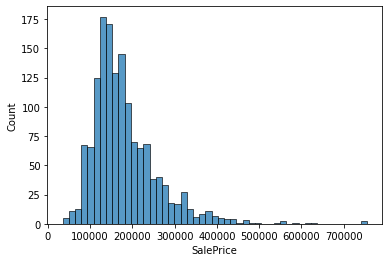

In [8]:
# it looks like that this variable is skewed to right. plotting histogram of SalePrice to check it's skewness-
sns.histplot(train['SalePrice'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

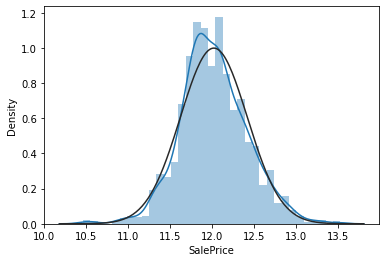

In [9]:
#it's skewed. to correct it we take log of the variable.
train_copy=train.copy()
train_copy['SalePrice']= np.log(train_copy['SalePrice'])
sns.distplot(train_copy['SalePrice'], fit=norm)

<AxesSubplot:>

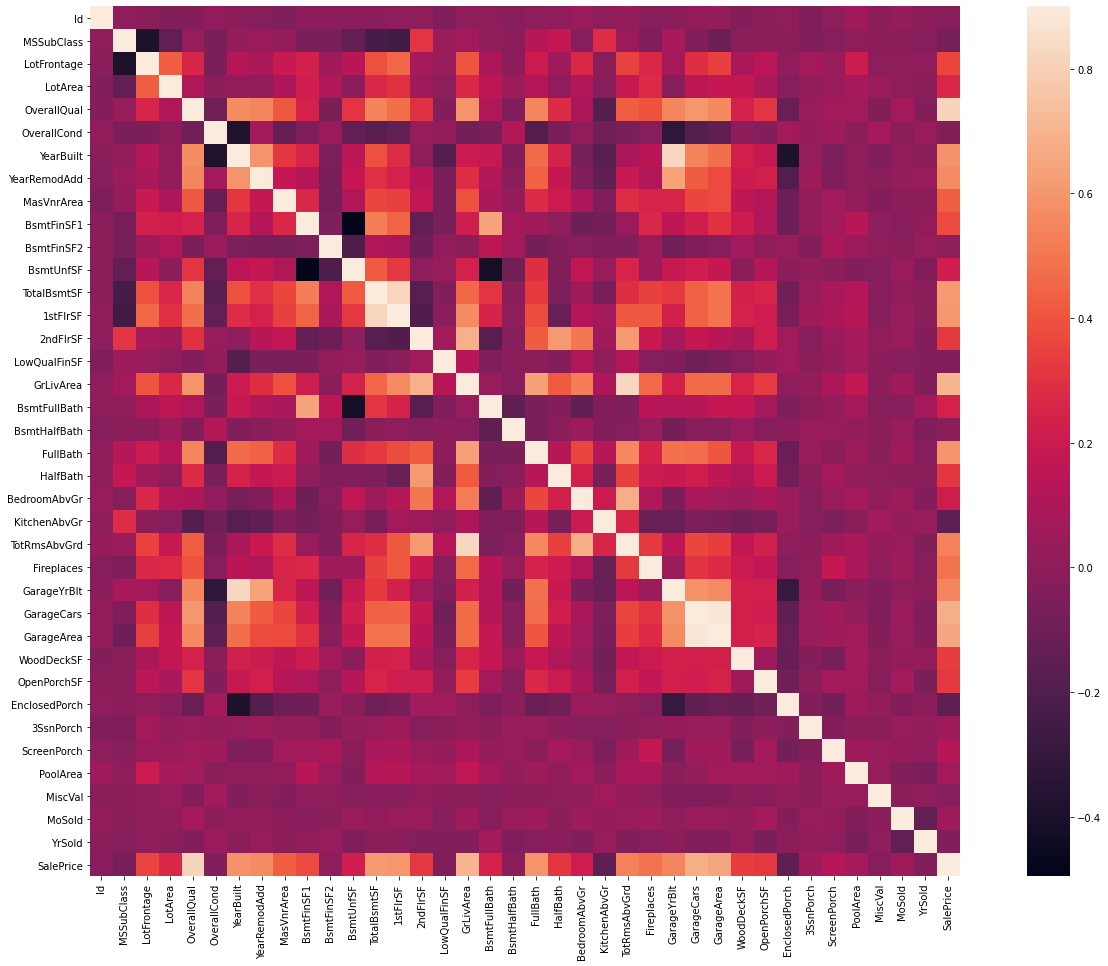

In [10]:
#It's looking normally distributed and not skewed. 
#Now, we will analyze correlation between independent variables
corre= train_copy.corr()
f, ax = plt.subplots(figsize=(24,16))
sns.heatmap(corre,vmax=0.9, square =True)

1. **GarageCars and GarageArea are highly correlated with each other
GarageYrBlt and YrBlt are correlated with each other
TotalBsmtSF and 1stFlrSF are correlated with each other**

2. **GrLiveArea and TotRmsAbvGrd are correlated with each other. so we will take only one of these variable in the model. Now we will check which variable has higher effect on SalePrice**

In [11]:
# Now we will see correlation of all independent variables with the dependent variable SalePrice
train_copy.corr().loc[:,'SalePrice'].abs().sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.817184
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489449
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355878
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209044
EnclosedPorch    0.149050
KitchenAbvGr     0.147548
ScreenPorch      0.121208
MSSubClass       0.073959
PoolArea         0.069798
MoSold           0.057329
3SsnPorch        0.054900
LowQualFinSF     0.037963
YrSold           0.037263
OverallCond      0.036868
MiscVal          0.020021
Id               0.017942
BsmtHalfBath     0.005149
BsmtFinSF2       0.004832
Name: SalePr

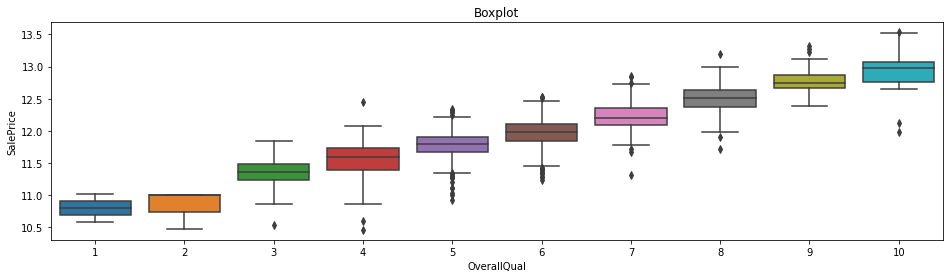

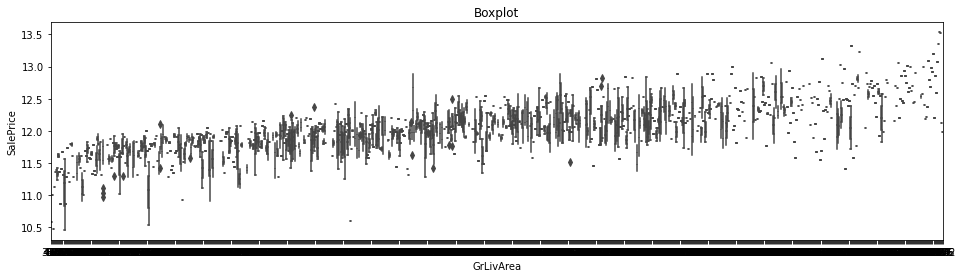

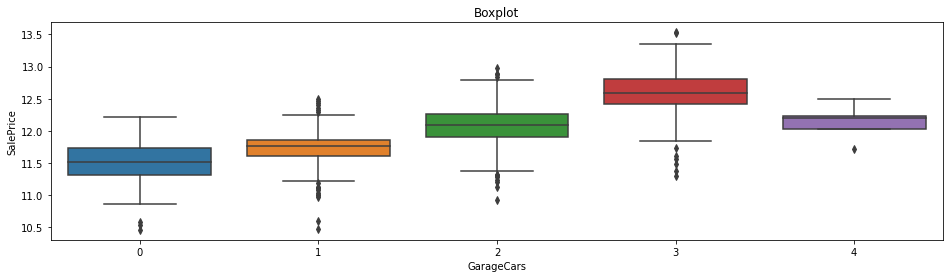

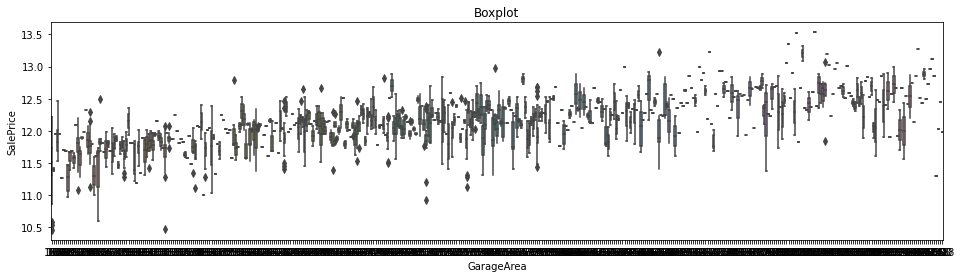

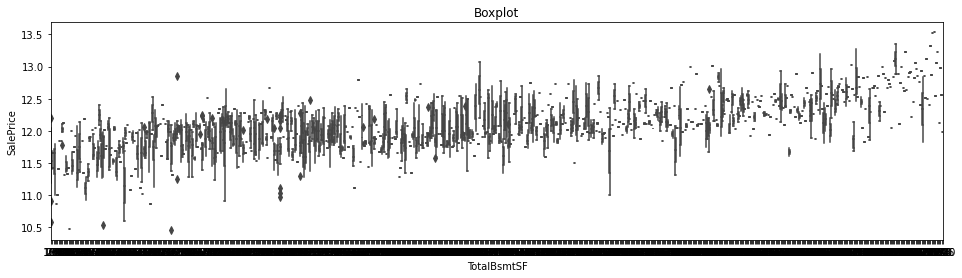

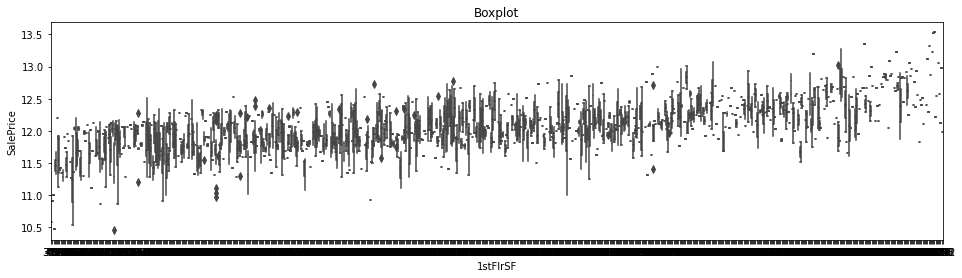

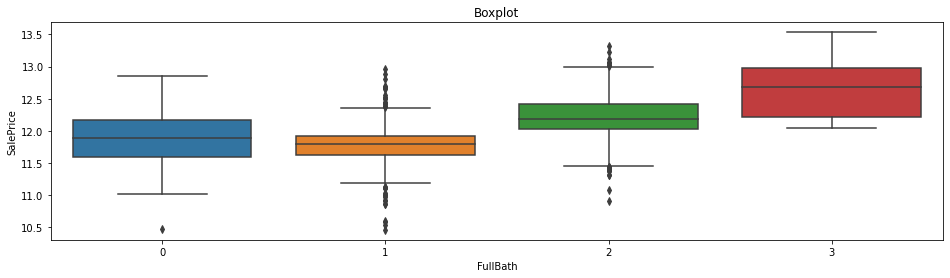

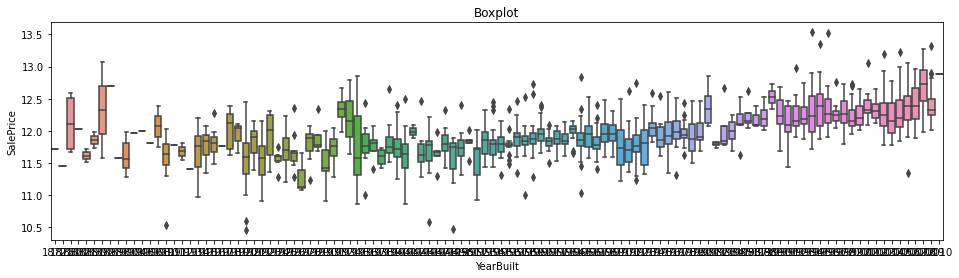

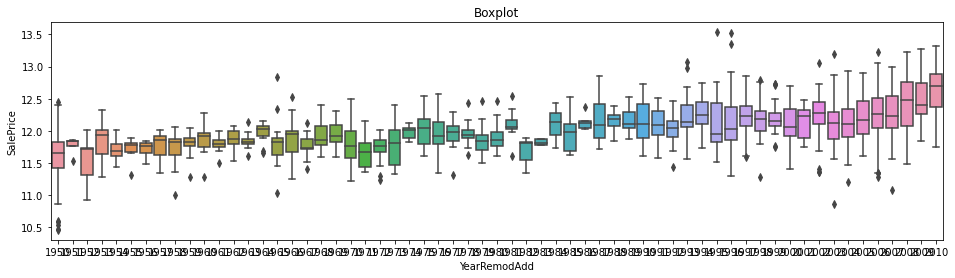

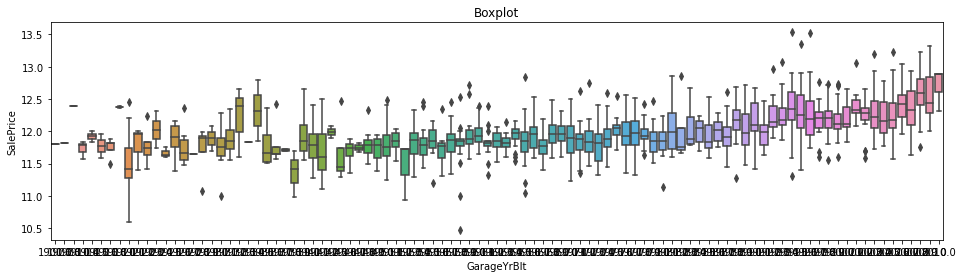

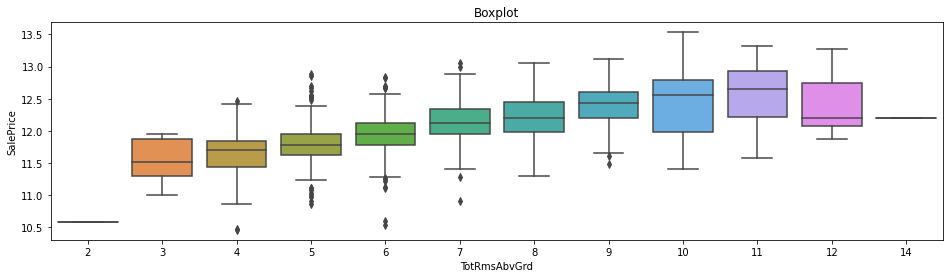

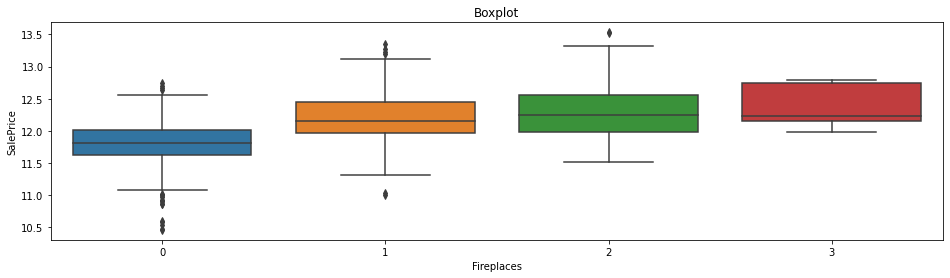

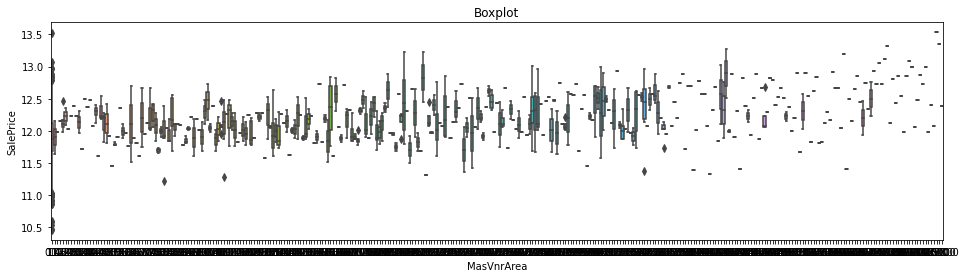

In [12]:
# we will see impact of all independent variables on the dependent varibale SalePrice
# Now we will se boxplots of all thosevaiables which have correaltion of more than 0.4 with SalePrice
def box(a):
    plt.figure(figsize=(16,4))
    sns.boxplot(x=train_copy[a],y=train_copy['SalePrice'])
    plt.title('Boxplot')
    plt.show()

col= ['OverallQual','GrLivArea','GarageCars','GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
'TotRmsAbvGrd', 'Fireplaces','MasVnrArea']
for i,j in enumerate(col):
    box(col[i])

**By seeing Boxplots of all the variables we can drop GarageCars, GarageYrBlt and TotRmsAbvGrd from our data.**

In [13]:
train_copy2=train_copy.drop(['GarageCars', 'GarageYrBlt' ,'TotRmsAbvGrd'], axis=1, inplace=False)

In [14]:
train_copy2.shape

(1460, 78)

In [15]:
train_copy.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,12.024051
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,0.399452
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460242
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.775097
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,12.001505
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,12.273731
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,13.534473


In [16]:
missing= train_copy2.isnull().sum().sort_values(ascending=False)
missing.head(25)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageFinish      81
GarageType        81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
MasVnrType         8
MasVnrArea         8
Electrical         1
KitchenAbvGr       0
Functional         0
HalfBath           0
FullBath           0
BsmtHalfBath       0
KitchenQual        0
BsmtFullBath       0
dtype: int64

We will add the two data sets (train and test) in one so that it would be easy for us to manipulate the same operation in both the data sets at a time.

In [17]:
SalePrice=train_copy2['SalePrice']
Id= test['Id']
Combined= pd.concat([train_copy,test],axis=0,sort=False)
Combined= Combined.drop(['SalePrice'],axis=1)

In [18]:
Combined.shape

(2919, 80)

In [19]:
# Dropping these 3 variables from whole the model as they were highly correlated and having no significant impact as such
Combined=Combined.drop(['GarageCars', 'GarageYrBlt' ,'TotRmsAbvGrd'], axis=1)

In [20]:
Combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [21]:
missing2= Combined.isnull().sum().sort_values(ascending=False)
missing2.head(20)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
dtype: int64

these first 5 columns have very high no of missing values so dropping all these columns will no affect my data interpretation.

In [22]:
Combined=Combined.drop(['PoolQC' ,'MiscFeature' , 'Alley', 'Fence' ,'FireplaceQu'],axis=1)


In [23]:
Combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [24]:
missing2=Combined.isnull().sum().sort_values(ascending=False)
missing2.head(30)

LotFrontage     486
GarageFinish    159
GarageCond      159
GarageQual      159
GarageType      157
BsmtExposure     82
BsmtCond         82
BsmtQual         81
BsmtFinType2     80
BsmtFinType1     79
MasVnrType       24
MasVnrArea       23
MSZoning          4
BsmtFullBath      2
Functional        2
BsmtHalfBath      2
Utilities         2
KitchenQual       1
BsmtUnfSF         1
BsmtFinSF2        1
TotalBsmtSF       1
Electrical        1
BsmtFinSF1        1
Exterior1st       1
Exterior2nd       1
SaleType          1
GarageArea        1
PoolArea          0
YrSold            0
MoSold            0
dtype: int64

In [25]:
missing_data= pd.concat([missing2],axis=1,keys=['missing'])
missing_data.head(30)


,missing
LotFrontage,486
GarageFinish,159
GarageCond,159
GarageQual,159
GarageType,157
BsmtExposure,82
BsmtCond,82
BsmtQual,81
BsmtFinType2,80
BsmtFinType1,79


In [26]:
Combined.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

So out of these columns which are having more than 20 NaN values only LotFrontage and MasVnrArea are float64 data types. rest of all are object datatypes. 
Now checking for these object data types variables for their importance on the SalePrice

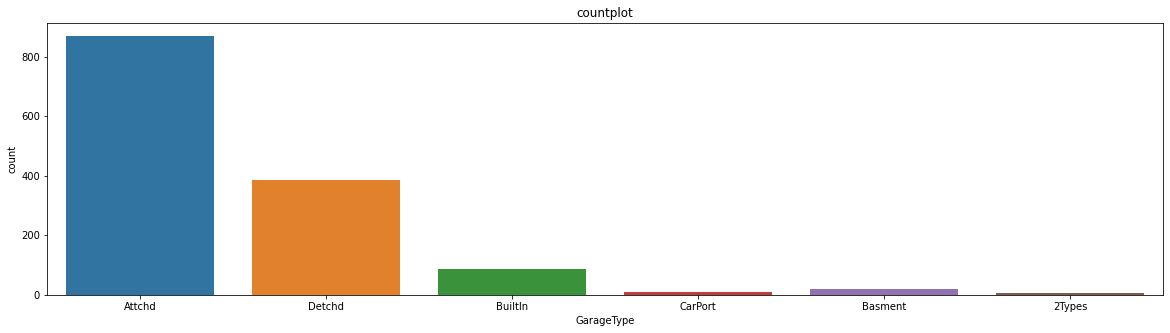

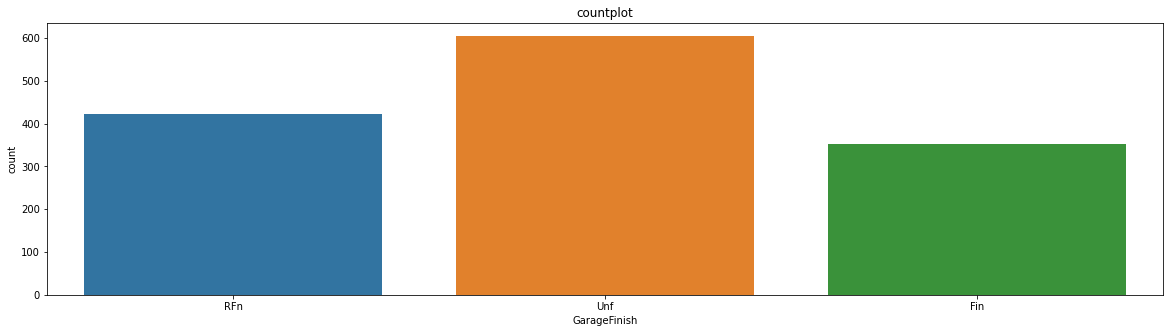

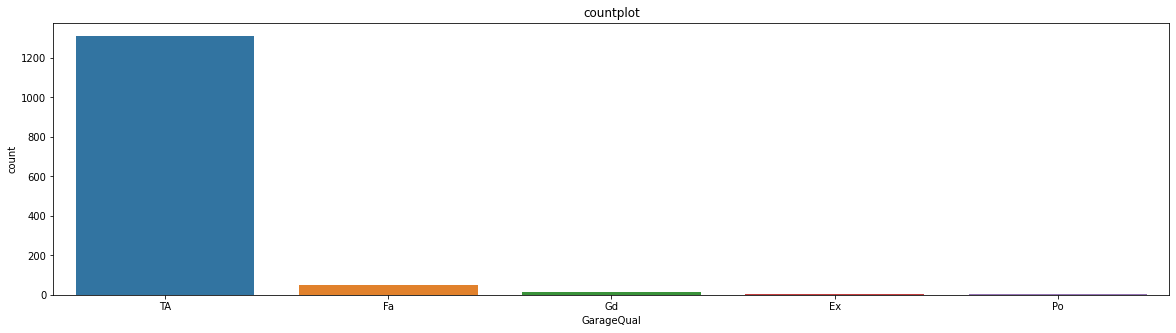

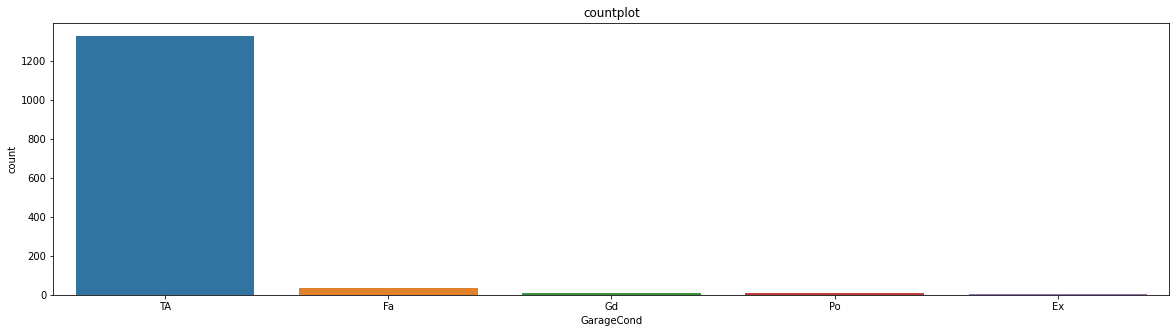

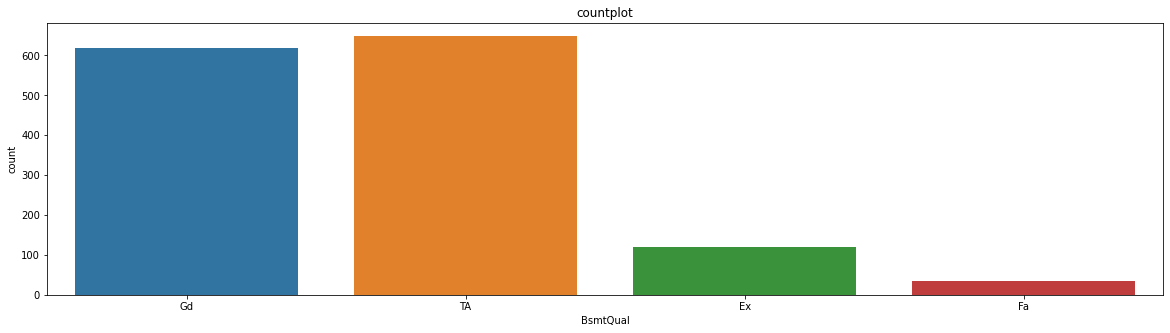

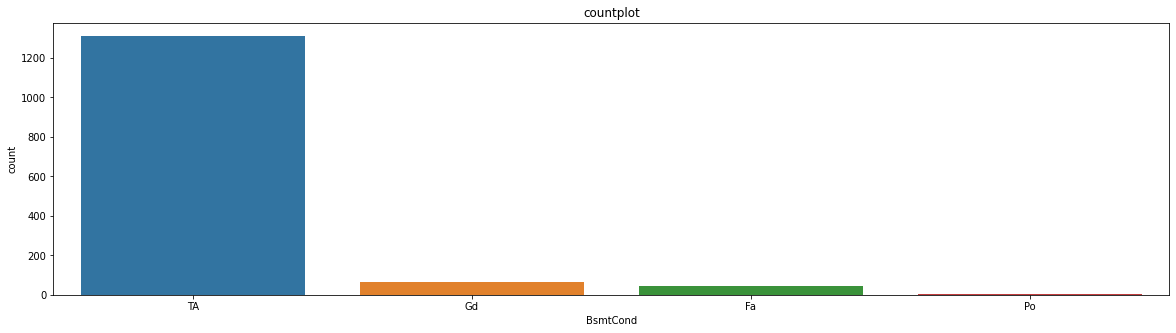

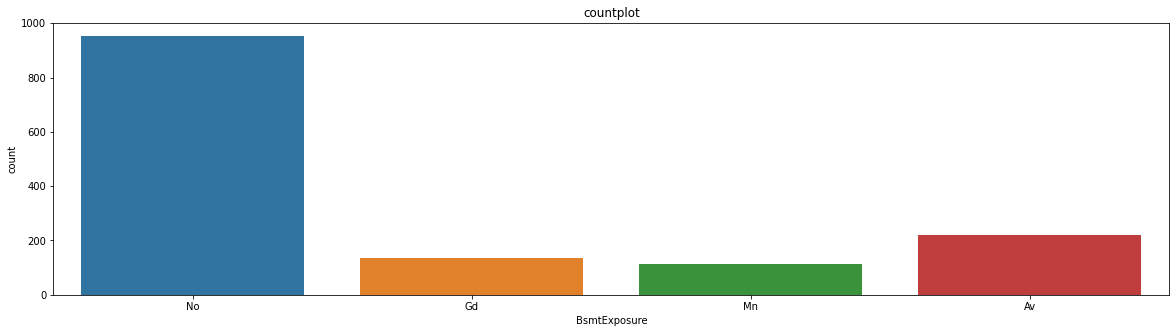

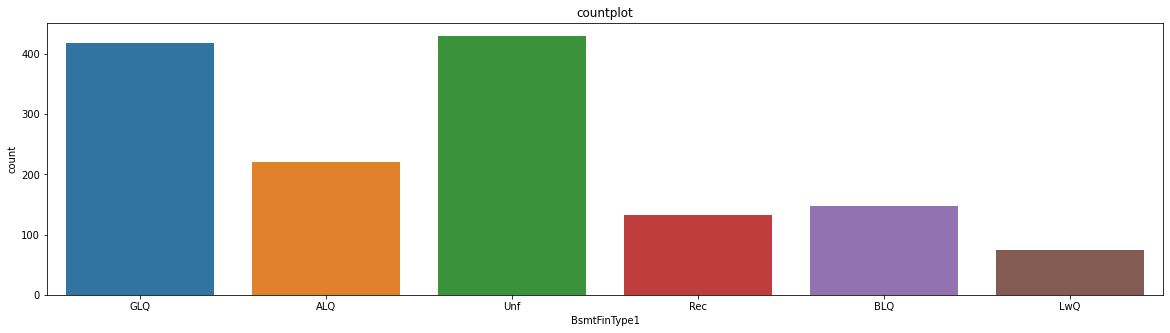

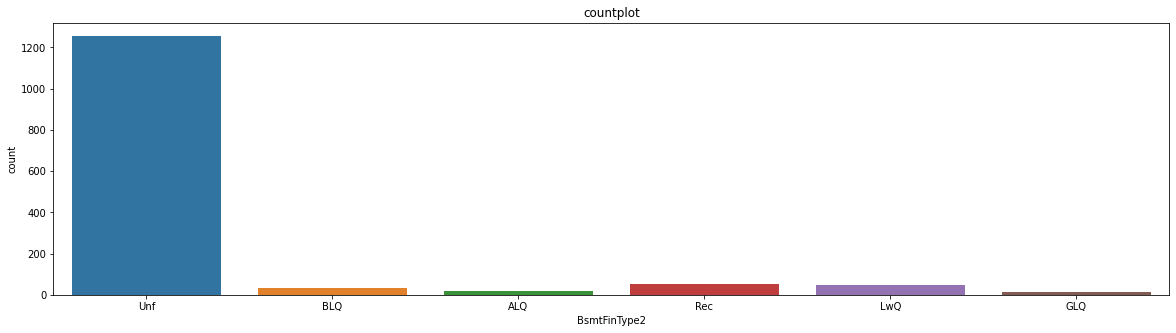

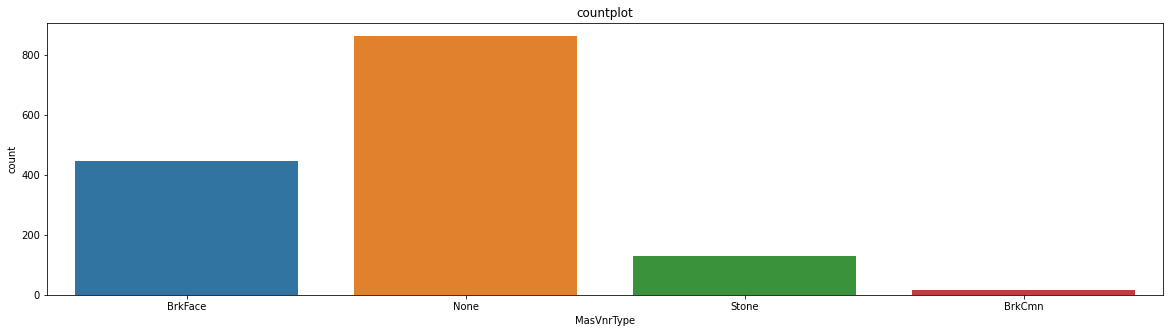

In [27]:
def count(a):
    plt.figure(figsize=(20,5))
    sns.countplot(x=train_copy2[a])
    plt.title('countplot')
    plt.show()
    
features=['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2','MasVnrType'] 
for i,j in enumerate(features):
    count(features[i])
    

In [28]:
pd.crosstab(train_copy2['BsmtFinType2'],columns='count',normalize= True)



col_0,count
BsmtFinType2,
ALQ,0.013361
BLQ,0.023207
GLQ,0.009845
LwQ,0.032349
Rec,0.037975
Unf,0.883263


Here only one category dominates the whole variable.

In [29]:
pd.crosstab(train_copy2['BsmtCond'],columns='count',normalize= True)


col_0,count
BsmtCond,
Fa,0.031623
Gd,0.045678
Po,0.001405
TA,0.921293


In [30]:
pd.crosstab(train_copy2['GarageCond'],columns='count',normalize= True)


col_0,count
GarageCond,
Ex,0.001450
Fa,0.025381
Gd,0.006526
Po,0.005076
TA,0.961566


Again,here TA dominates the whole variable.

In [31]:
pd.crosstab(train_copy2['GarageQual'],columns='count',normalize= True)

col_0,count
GarageQual,
Ex,0.002175
Fa,0.034808
Gd,0.010152
Po,0.002175
TA,0.950689


Here, again TA dominates the whole variable.

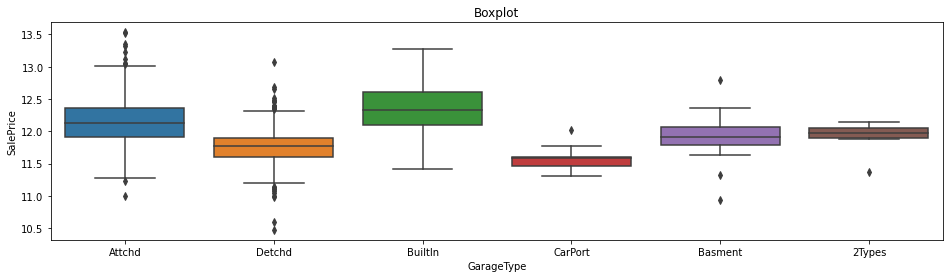

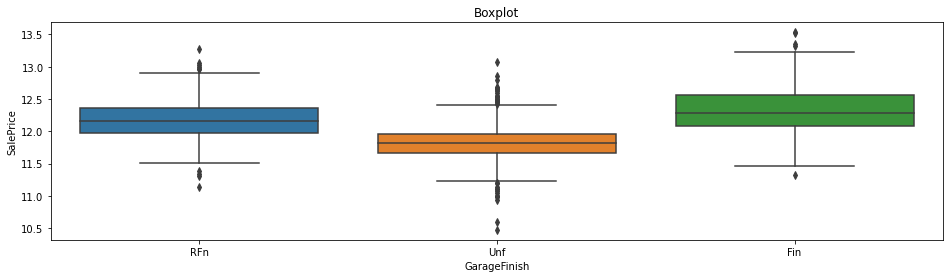

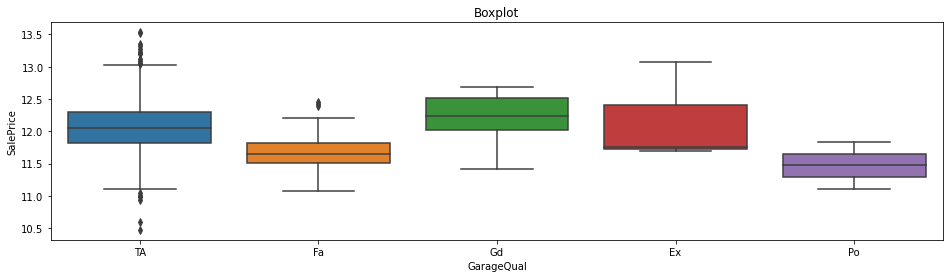

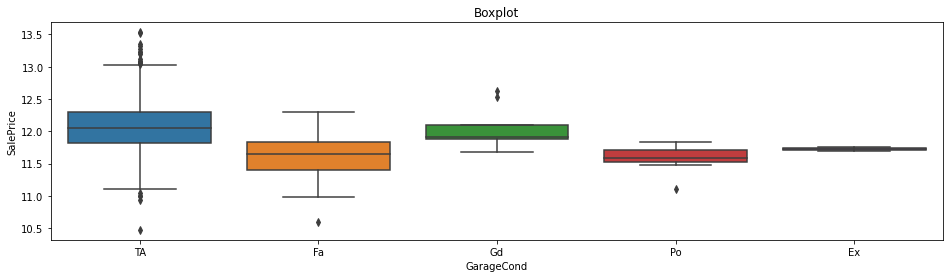

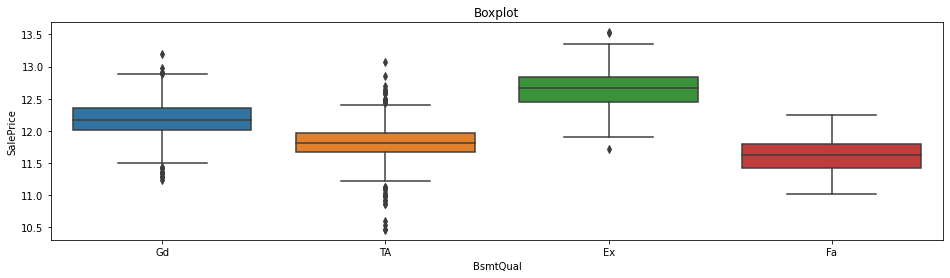

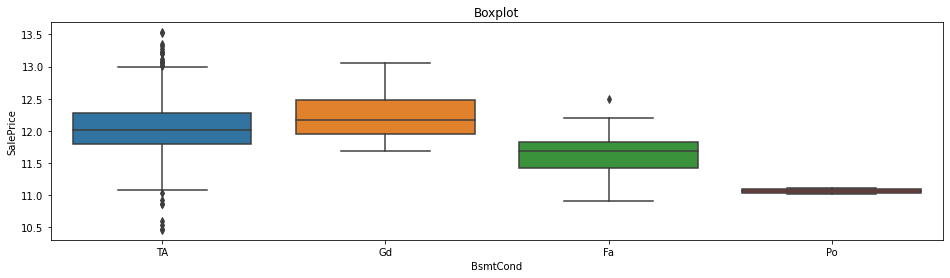

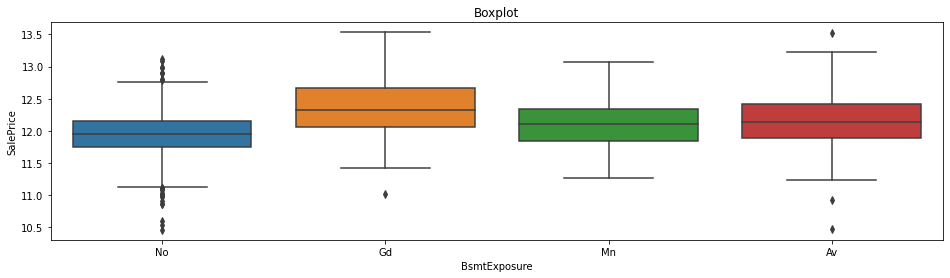

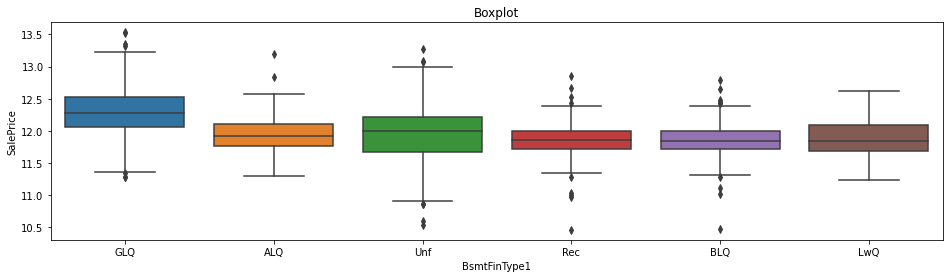

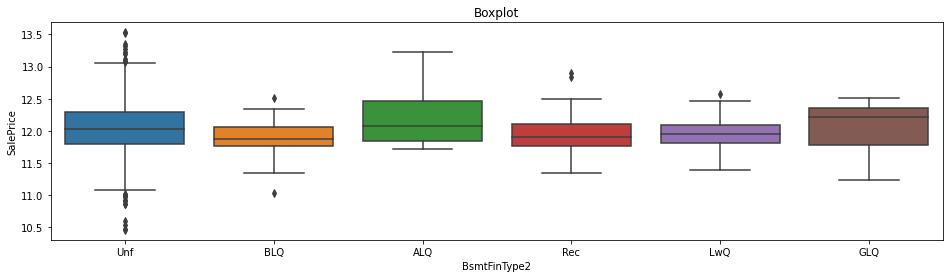

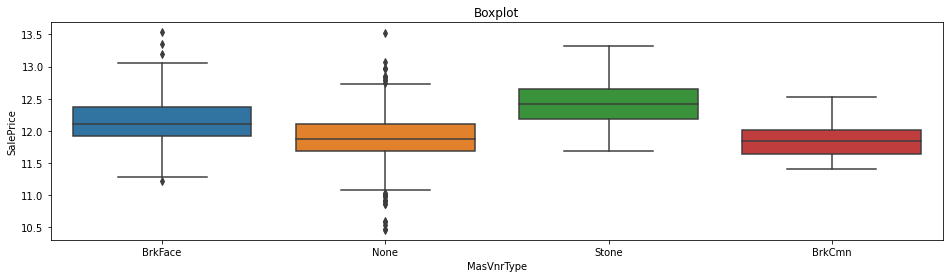

In [32]:
for i,j in enumerate(features):
    box(features[i])

As BsmtFinType1 and BsmtFinType2 has approximately same median for all the categories they don't have much categorical effect on the saleprice. So we will drop out these variable.

In [33]:
Combined= Combined.drop(['BsmtFinType1','BsmtFinType2'],axis=1)
Combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [34]:
Combined.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 70, dtype: int64

Now as we have seen that these object type variables effect my SalePrice significantly so we will fill out these columns' NaN values by their mode value.

In [35]:
features_new= ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure','MasVnrType']
for a in features_new:
    Combined[a]= Combined[a].fillna(Combined[a].mode()[0])

Now Checking for the other data type columns which were having NaN values in their data

In [36]:
Combined['LotFrontage'].describe()

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [37]:
Combined['MasVnrArea'].describe()

count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

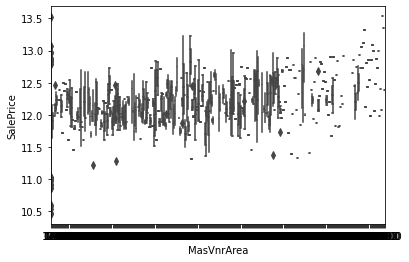

In [38]:
sns.boxplot(x=train_copy2['MasVnrArea'],y= train_copy2['SalePrice'])

MasVnrArea is very highly skewed. So we will drop this variable.

In [39]:
Combined2= Combined.drop(['MasVnrArea'],axis=1)


In [40]:
Combined2['LotFrontage']= Combined2['LotFrontage'].fillna(Combined2['LotFrontage'].mean())
missing3= Combined2.isnull().sum().sort_values(ascending=False)
missing3.head(30)

MSZoning        4
BsmtFullBath    2
Utilities       2
BsmtHalfBath    2
Functional      2
TotalBsmtSF     1
BsmtUnfSF       1
Exterior2nd     1
BsmtFinSF2      1
BsmtFinSF1      1
Exterior1st     1
SaleType        1
Electrical      1
KitchenQual     1
GarageArea      1
KitchenAbvGr    0
LowQualFinSF    0
BedroomAbvGr    0
HalfBath        0
GrLivArea       0
2ndFlrSF        0
FullBath        0
GarageType      0
Fireplaces      0
GarageFinish    0
GarageQual      0
GarageCond      0
PavedDrive      0
WoodDeckSF      0
OpenPorchSF     0
dtype: int64

In [41]:
Combined.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [42]:
features_2= ['MSZoning','Utilities','Functional','Exterior2nd','Exterior1st','SaleType','Electrical','KitchenQual']
for a in features_2:
    Combined2[a]=Combined2[a].fillna(Combined2[a].mode()[0])
Combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

Now, we will correct our data for skewness.

In [43]:
no_skew = Combined2.dtypes[Combined2.dtypes != 'object'].index
skewed = Combined2[no_skew].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skewed = skewed[abs(skewed) > 0.5]
high_skewed

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
EnclosedPorch     4.003891
ScreenPorch       3.946694
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.645574
1stFlrSF          1.469604
MSSubClass        1.375457
GrLivArea         1.269358
2ndFlrSF          0.861675
Fireplaces        0.733495
HalfBath          0.694566
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64

In [44]:
for a in no_skew:
    Combined2[a]=np.log1p(Combined2[a])

In [45]:
# Now as TotalBsmtSF , 1stFlrSF and 2ndFlrSF are highly correlated so introducing a new variable with taking there average
Combined2['AvgSF']=((Combined2['TotalBsmtSF']+Combined2['1stFlrSF']+Combined2['2ndFlrSF'])/3)
Combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   float64
 1   MSSubClass     2919 non-null   float64
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   float64
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   float64
 17  OverallCond    2919 non-null   float64
 18  YearBuil

In [46]:
Combined2.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)
Combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 67 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   float64
 1   MSSubClass     2919 non-null   float64
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   float64
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   float64
 17  OverallCond    2919 non-null   float64
 18  YearBuil

In [47]:
Combined2.select_dtypes(include=['object']).columns


Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

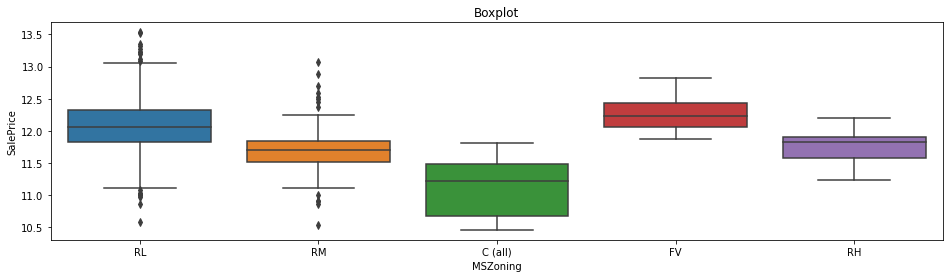

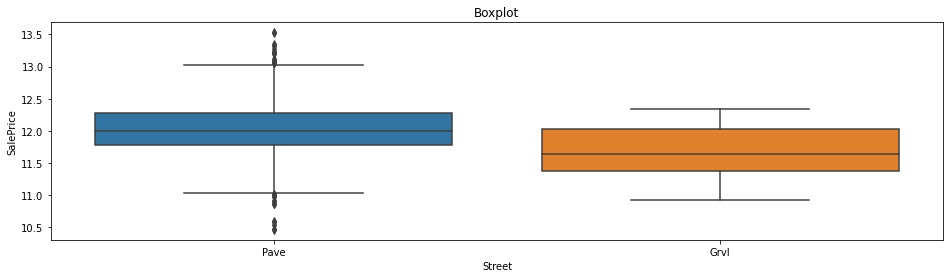

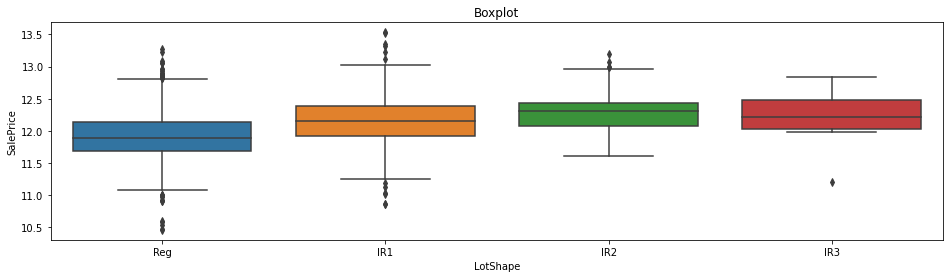

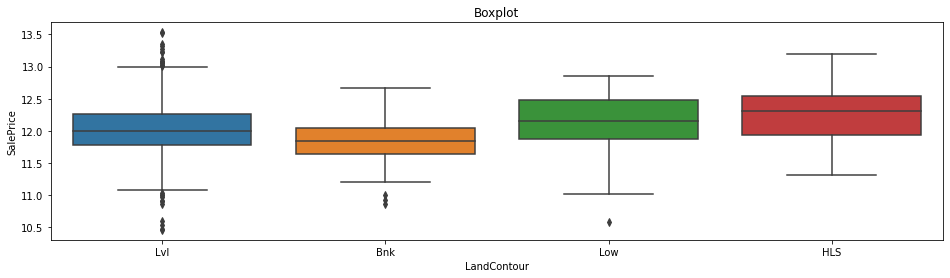

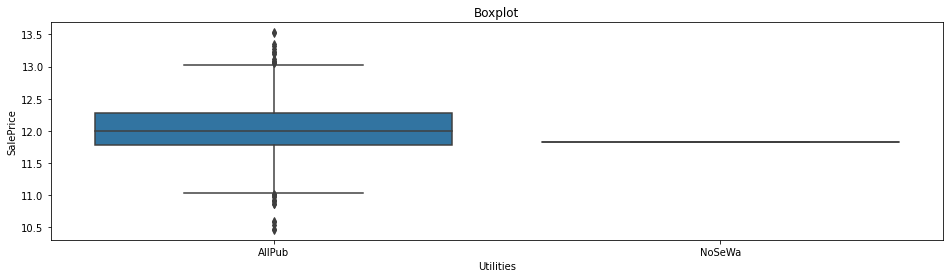

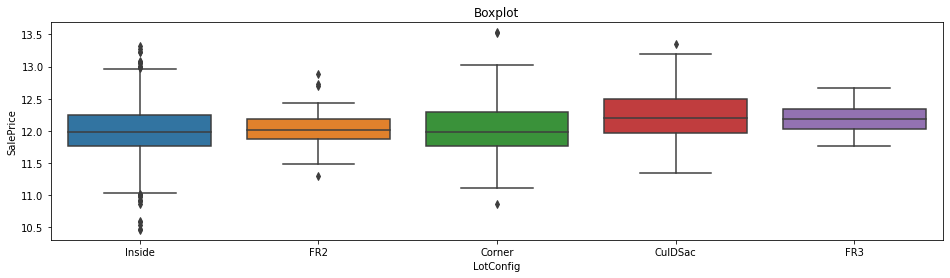

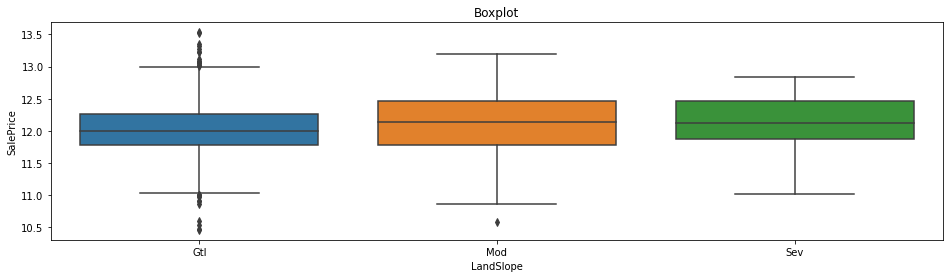

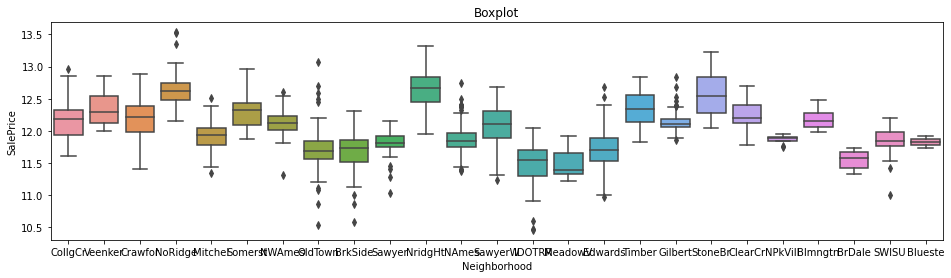

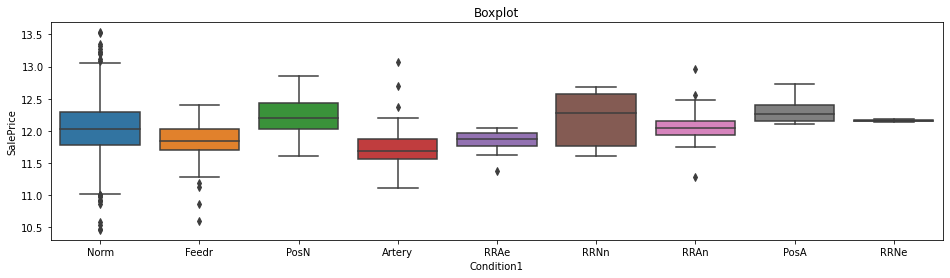

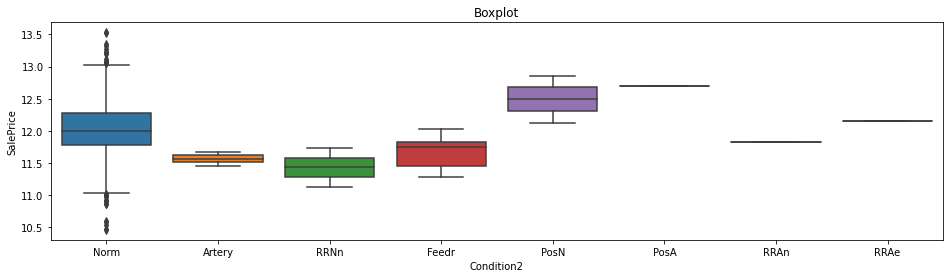

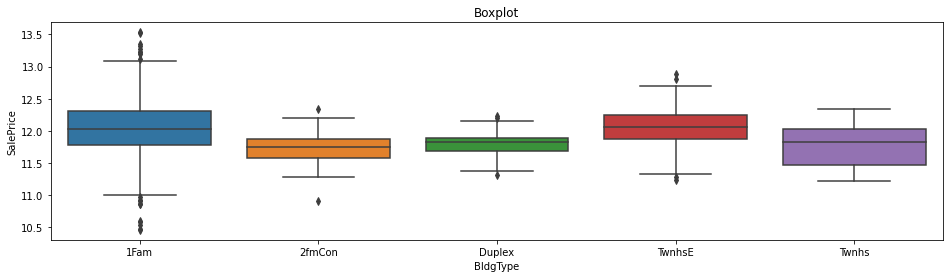

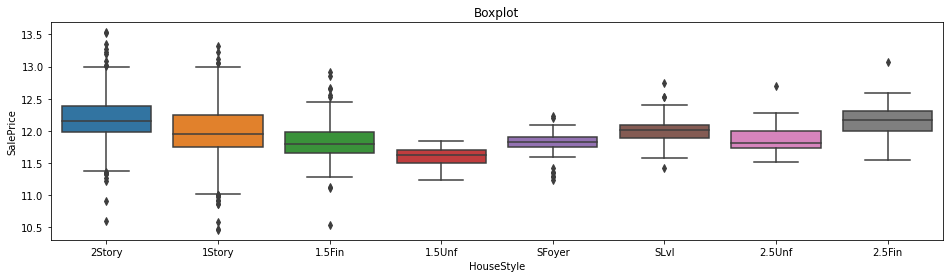

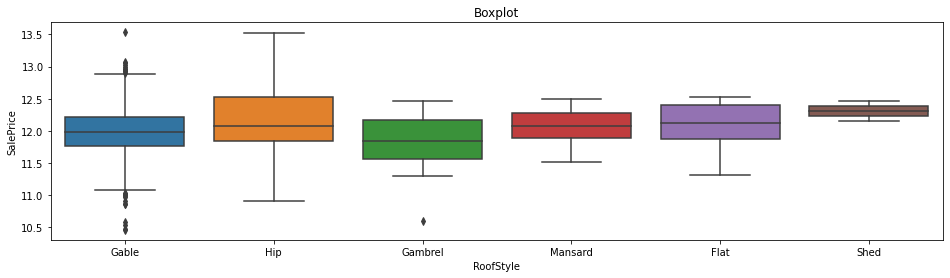

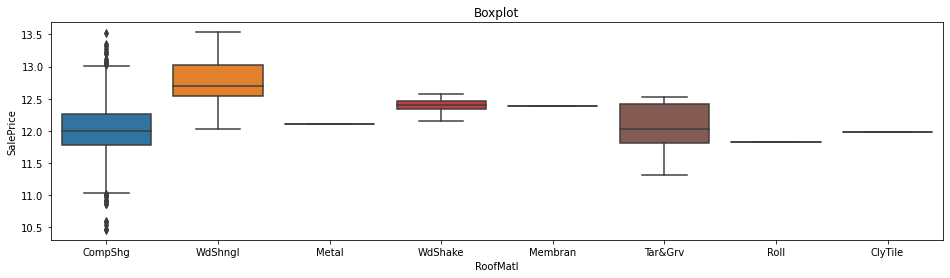

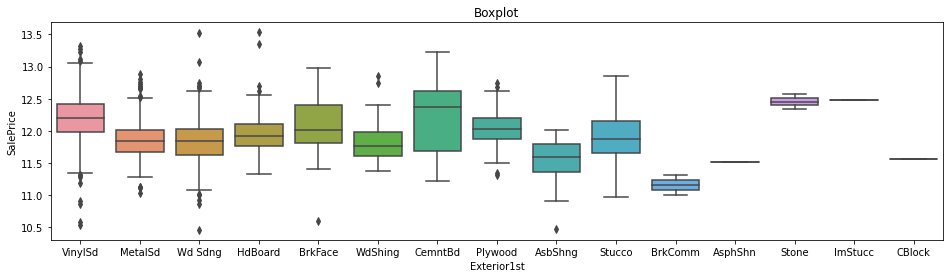

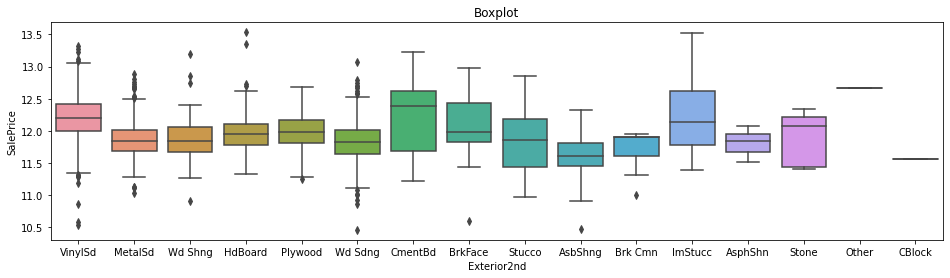

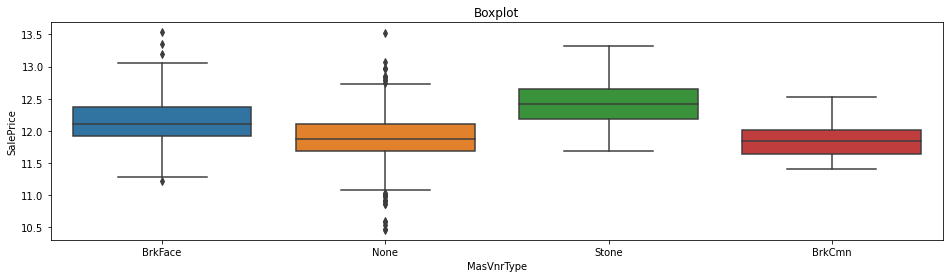

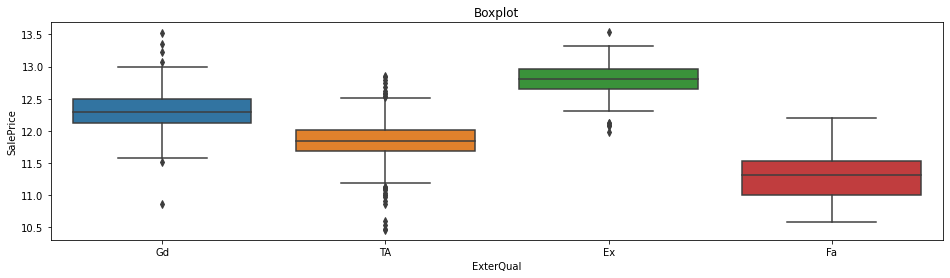

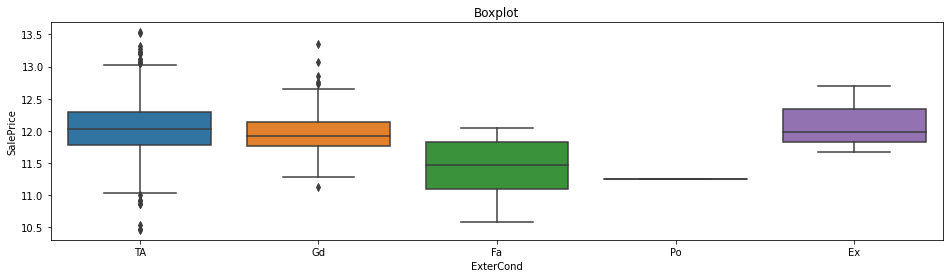

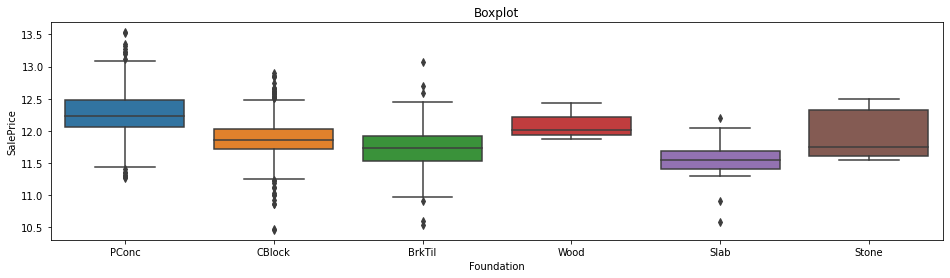

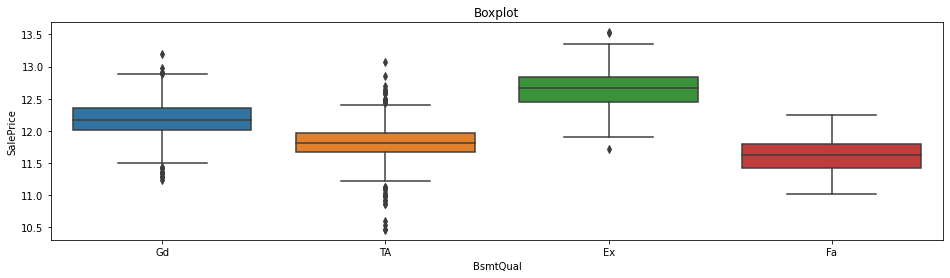

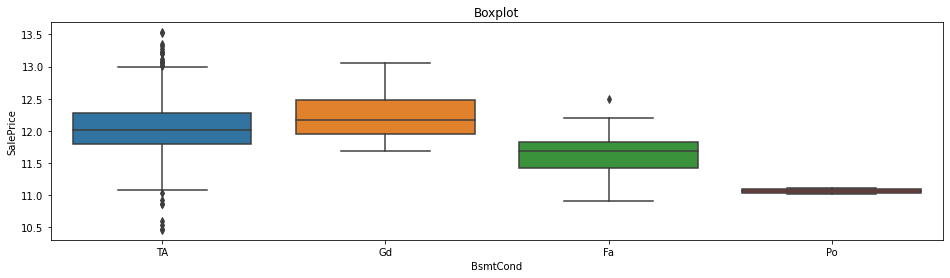

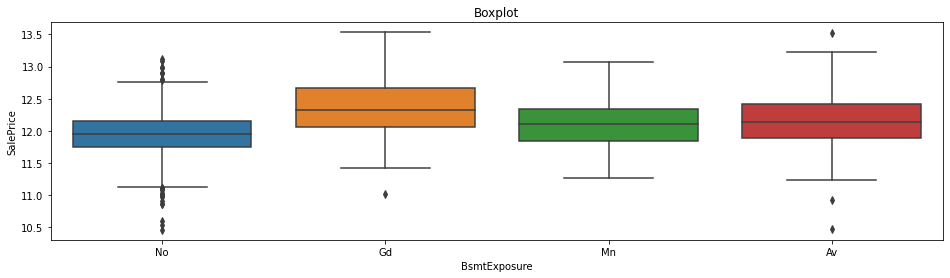

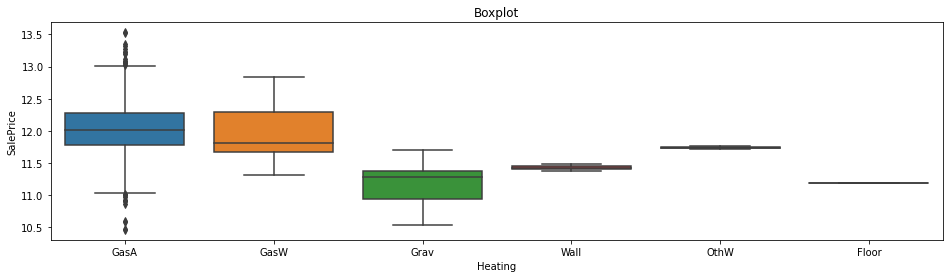

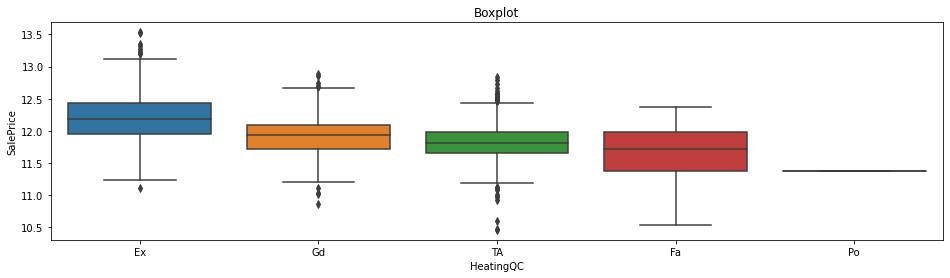

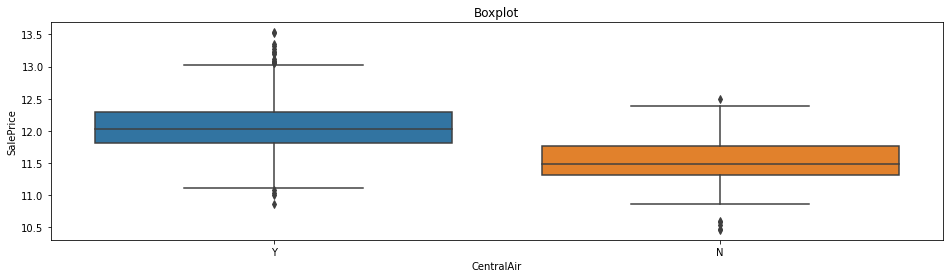

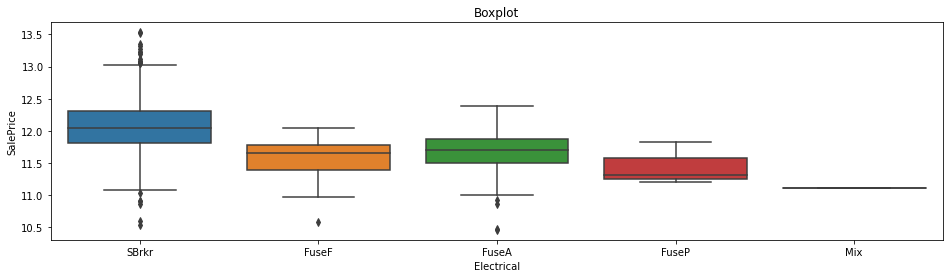

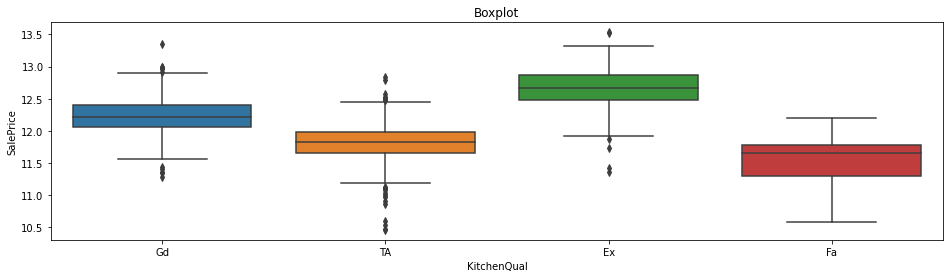

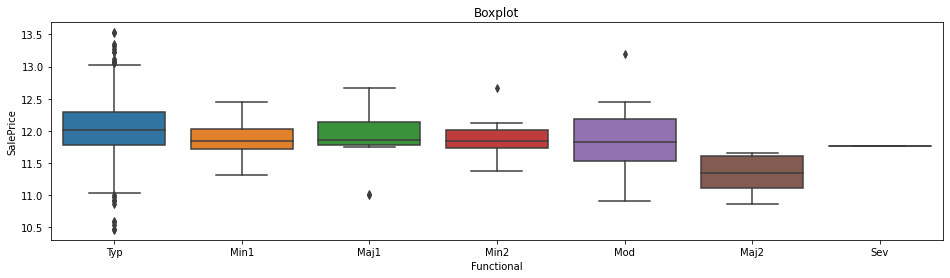

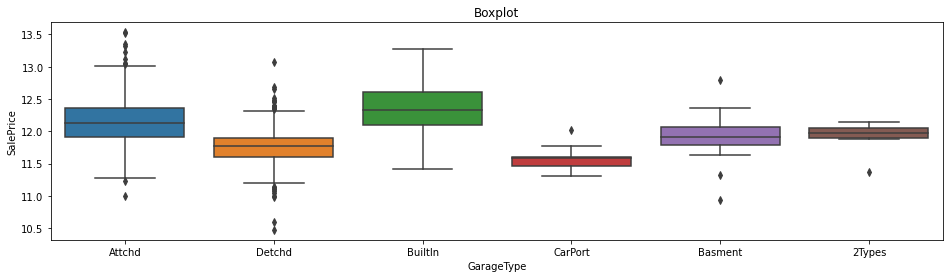

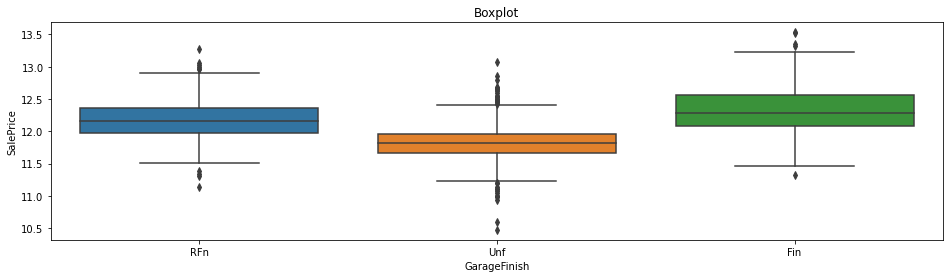

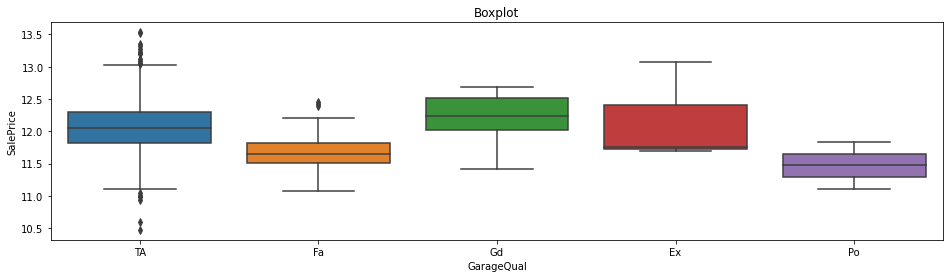

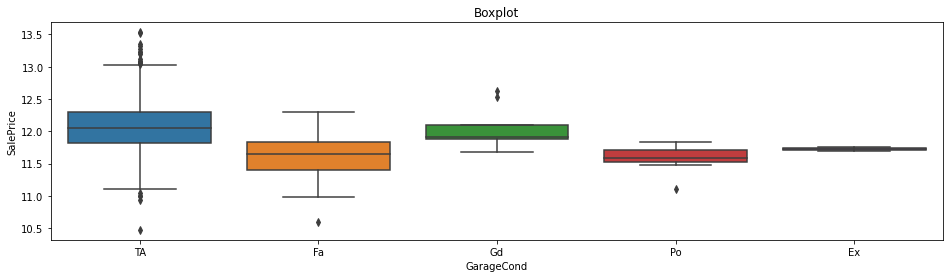

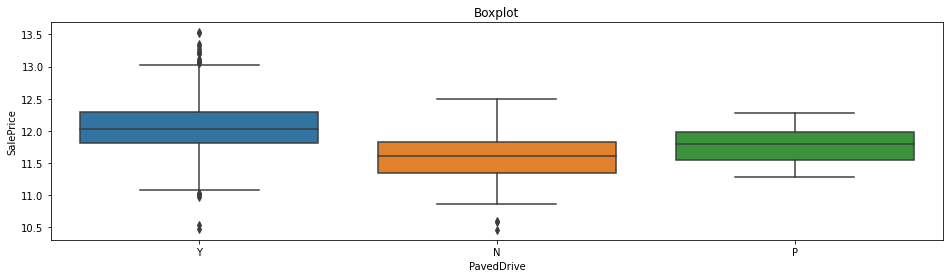

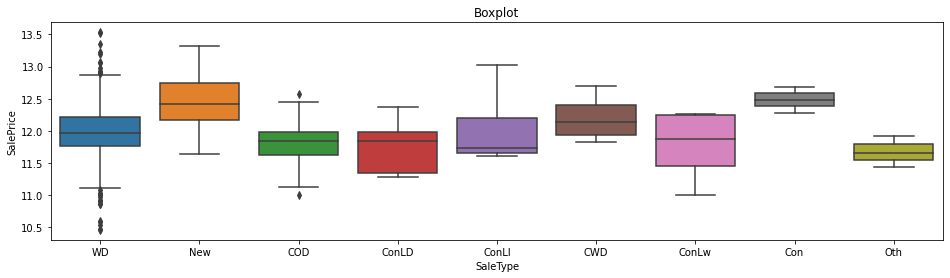

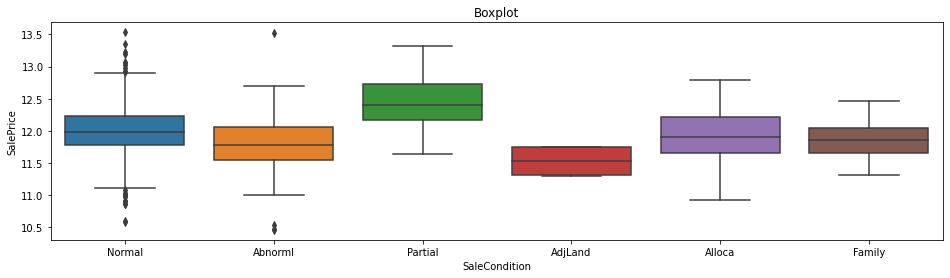

In [48]:
features2=['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition']
for i,j in enumerate(features2):
    box(features2[i])

as no categorical effect of LotConfig and LandSlope so we will drop these.

In [49]:
pd.crosstab(Combined2['Utilities'],columns='count',normalize=True)

col_0,count
Utilities,
AllPub,0.999657
NoSeWa,0.000343


As it's highly skewed so we will drop this variable also

In [50]:
Combined2.drop(['LotConfig','LandSlope','Utilities'],axis=1,inplace=True)


In [51]:
Combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   float64
 1   MSSubClass     2919 non-null   float64
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   float64
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Neighborhood   2919 non-null   object 
 9   Condition1     2919 non-null   object 
 10  Condition2     2919 non-null   object 
 11  BldgType       2919 non-null   object 
 12  HouseStyle     2919 non-null   object 
 13  OverallQual    2919 non-null   float64
 14  OverallCond    2919 non-null   float64
 15  YearBuilt      2919 non-null   float64
 16  YearRemodAdd   2919 non-null   float64
 17  RoofStyle      2919 non-null   object 
 18  RoofMatl

Now, we will fill out all NaN values with the mean values.

In [52]:
Features_numeric=['AvgSF','GarageArea','BsmtHalfBath','BsmtFullBath','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']
for a in Features_numeric:
    Combined2[a]=Combined2[a].fillna(Combined2[a].mean())
Combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   float64
 1   MSSubClass     2919 non-null   float64
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   float64
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Neighborhood   2919 non-null   object 
 9   Condition1     2919 non-null   object 
 10  Condition2     2919 non-null   object 
 11  BldgType       2919 non-null   object 
 12  HouseStyle     2919 non-null   object 
 13  OverallQual    2919 non-null   float64
 14  OverallCond    2919 non-null   float64
 15  YearBuilt      2919 non-null   float64
 16  YearRemodAdd   2919 non-null   float64
 17  RoofStyle      2919 non-null   object 
 18  RoofMatl

Now, we are all up with data cleaning. Now we will apply regression Techniques to our model

In [53]:
##Changing categorical to numerical
new_data=pd.get_dummies(Combined2, drop_first=True)
new_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.693147,4.110874,4.189655,9.042040,2.079442,1.791759,7.602900,7.602900,6.561031,0.0,...,0,0,0,0,1,0,0,0,1,0
1,1.098612,3.044522,4.394449,9.169623,1.945910,2.197225,7.589336,7.589336,6.886532,0.0,...,0,0,0,0,1,0,0,0,1,0
2,1.386294,4.110874,4.234107,9.328212,2.079442,1.791759,7.601902,7.602401,6.188264,0.0,...,0,0,0,0,1,0,0,0,1,0
3,1.609438,4.262680,4.110874,9.164401,2.079442,1.791759,7.557995,7.586296,5.379897,0.0,...,0,0,0,0,1,0,0,0,0,0
4,1.791759,4.110874,4.442651,9.565284,2.197225,1.791759,7.601402,7.601402,6.486161,0.0,...,0,0,0,0,1,0,0,0,1,0


As we had combined the test and train data with each other so now we will separate out both the data sets.

In [54]:
x_train= new_data[:len(SalePrice)]
x_test= new_data[len(SalePrice):]

In [55]:
x_train.shape


(1460, 210)

In [56]:
x_test.shape

(1459, 210)

In [57]:
x_train.tail()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1455,7.284135,4.110874,4.143135,8.976894,1.945910,1.791759,7.600902,7.601402,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
1456,7.284821,3.044522,4.454347,9.486152,1.945910,1.945910,7.590347,7.595387,6.673298,5.099866,...,0,0,0,0,1,0,0,0,1,0
1457,7.285507,4.262680,4.204693,9.109746,2.079442,2.302585,7.571474,7.604396,5.620401,0.000000,...,0,0,0,0,1,0,0,0,1,0
1458,7.286192,3.044522,4.234107,9.181735,1.791759,1.945910,7.576097,7.599401,3.912023,6.937314,...,0,0,0,0,1,0,0,0,1,0
1459,7.286876,3.044522,4.330733,9.204121,1.791759,1.945910,7.583756,7.583756,6.722630,5.673323,...,0,0,0,0,1,0,0,0,1,0


In [58]:
x_test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,7.287561,3.044522,4.394449,9.360741,1.791759,1.945910,7.581720,7.581720,6.150603,4.976734,...,0,0,0,0,1,0,0,0,1,0
1,7.288244,3.044522,4.406719,9.565775,1.945910,1.945910,7.580189,7.580189,6.828712,0.000000,...,0,0,0,0,1,0,0,0,1,0
2,7.288928,4.110874,4.317488,9.534668,1.791759,1.791759,7.599902,7.600402,6.674561,0.000000,...,0,0,0,0,1,0,0,0,1,0
3,7.289611,4.110874,4.369448,9.208238,1.945910,1.945910,7.600402,7.600402,6.401917,0.000000,...,0,0,0,0,1,0,0,0,1,0
4,7.290293,4.795791,3.784190,8.518392,2.197225,1.791759,7.597396,7.597396,5.575949,0.000000,...,0,0,0,0,1,0,0,0,1,0


**Creating test and train data randomly out of train data so that we can figure out which algorithm is having best goodness of fit and least rmse.**

In [59]:
x_train= x_train.drop(['Id'],axis=1)
x_test= x_test.drop(['Id'],axis=1)

In [60]:
y_train= SalePrice

In [61]:
train_x,test_x,train_y,test_y=train_test_split(x_train,y_train,test_size=0.25,random_state=12)


# 1. DecisionTreeRegressor

In [62]:
dtr=  DecisionTreeRegressor()


In [63]:
dtr.fit(train_x,train_y)

DecisionTreeRegressor()

In [64]:
prediction_dtr=dtr.predict(test_x)

In [65]:
dtr_mse= mean_squared_error(test_y,prediction_dtr)
dtr_rmse=np.sqrt(dtr_mse)
print(dtr_rmse)

0.23177948534375464


In [66]:
r2_dtr_train=dtr.score(train_x,train_y)
r2_dtr_test=dtr.score(test_x,test_y)
print(r2_dtr_train,r2_dtr_test)

1.0 0.6872728335537881


<AxesSubplot:ylabel='SalePrice'>

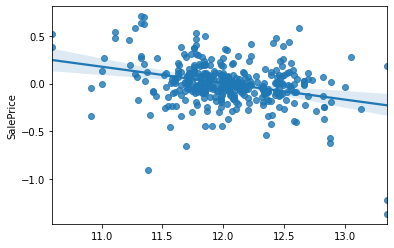

In [67]:
Residuals=test_y-prediction_dtr
sns.regplot(x=prediction_dtr,y=Residuals,scatter=True,fit_reg=True,data=new_data)

# 2. RandomForestRegressor

In [68]:
rfr=RandomForestRegressor()


In [69]:
rfr.fit(train_x,train_y)


RandomForestRegressor()

In [70]:
prediction_rfr= rfr.predict(test_x)

In [71]:
mse_rfr=mean_squared_error(test_y,prediction_rfr)
rmse_rfr=np.sqrt(mse_rfr)


In [72]:
print(rmse_rfr)

0.1653412359472895


In [73]:
r2_rfr_train= rfr.score(train_x,train_y)
r2_rfr_test=rfr.score(test_x,test_y)
print(r2_rfr_test,r2_rfr_train)

0.8408605030680486 0.9819865886936724


<AxesSubplot:ylabel='SalePrice'>

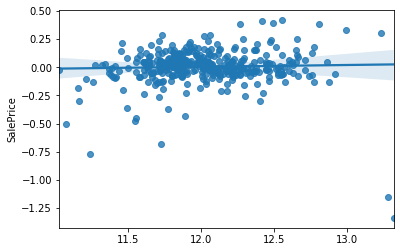

In [74]:
Residuals2=test_y-prediction_rfr
sns.regplot(x=prediction_rfr,y=Residuals2,scatter=True,fit_reg=True,data=new_data)

# 3. XGBRegressor

In [75]:
xgb= XGBRegressor()



In [76]:
xgb.fit(train_x, train_y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
prediction_xgb=xgb.predict(test_x)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [78]:
mse_xgb=mean_squared_error(test_y,prediction_xgb)
rmse_xgb=np.sqrt(mse_xgb)
print(rmse_xgb)

0.17121901210566887


In [79]:
r2_xgb_train= xgb.score(train_x,train_y)
r2_xgb_test= xgb.score(test_x,test_y)
print(r2_xgb_train,' ',r2_xgb_test)

0.9995112988556359   0.8293447728112431


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


<AxesSubplot:ylabel='SalePrice'>

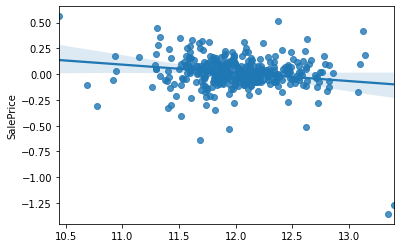

In [80]:
Residuals3=test_y-prediction_xgb
sns.regplot(x=prediction_xgb,y=Residuals3,fit_reg=True,scatter=True,data=new_data)

# 4. LinearRegression

In [81]:
Linreg= LinearRegression()

In [82]:
Linreg.fit(train_x,train_y)

LinearRegression()

In [83]:
prediction_Linreg=Linreg.predict(test_x)

In [84]:
mse_Linreg=mean_squared_error(test_y,prediction_Linreg)
rmse_Linreg=np.sqrt(mse_Linreg)
print(rmse_Linreg)

0.1608576533034805


In [85]:
r2_Linreg_train= Linreg.score(train_x,train_y)
r2_Linreg_test=Linreg.score(test_x,test_y)
print(r2_Linreg_train,r2_Linreg_test)

0.9441146955629682 0.8493742998292757


<AxesSubplot:ylabel='SalePrice'>

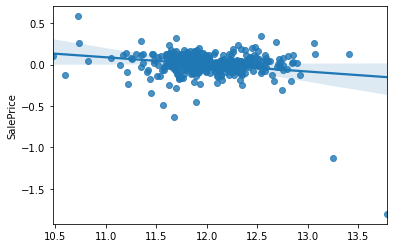

In [86]:
Residuals4=test_y-prediction_Linreg
sns.regplot(x=prediction_Linreg,y=Residuals4,scatter=True,fit_reg=True,data=new_data)

Linear regression algorithm has given best r2_score and least rmse value.

In [87]:
prediction_final=np.exp(Linreg.predict(x_test))
print(prediction_final)

[126772.10917227 152459.3687928  184286.22581325 ... 171632.25996561
 123680.67013606 213460.11813935]


In [88]:
data_set= pd.DataFrame()
data_set['Id']= Id
data_set['SalePrice']=prediction_final
data_set.to_csv('Price_projection_project1.csv',index=False)


In [89]:
prediction_rfr_final= np.exp(rfr.predict(x_test))

In [90]:
data_set2= pd.DataFrame()
data_set2['Id']=Id
data_set2['SalePrice']=prediction_rfr_final
data_set2.to_csv('price_projection_project1_2.csv',index=False)